<a href="https://colab.research.google.com/github/SirigireddyAbhignaReddy/Stock-Market-Price-Prediction/blob/main/IBM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/SirigireddyAbhignaReddy/Stock-Market-Price-Prediction.git

Cloning into 'Stock-Market-Price-Prediction'...


In [2]:
pip install newsapi-python


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import nltk

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize News API Client with your API key
newsapi = NewsApiClient(api_key='b3a308ef3c9c42c1a4d8cd4091e6a291')

# Function to evaluate model's performance
def evaluate_model(predictions, actual_values):
    rmse = math.sqrt(mean_squared_error(actual_values, predictions))
    mape = mean_absolute_percentage_error(actual_values, predictions) * 100
    accuracy_percentage = 100 - mape
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'The accuracy of the model is {accuracy_percentage:.2f}%.')

# Load stock price data
def load_data(ticker):
    df = yf.download(ticker, start='2010-01-01', end='2024-11-28')
    return df

# Fetch news headlines
# def fetch_news(ticker, start_date, end_date):
#     all_articles = newsapi.get_everything(
#         q=ticker,  # Query for the stock ticker (e.g., "AAPL")
#         from_param=start_date,
#         to=end_date,
#         language='en',
#         sort_by='relevancy',
#     )
#     headlines = [article['title'] for article in all_articles['articles']]
#     dates = [article['publishedAt'][:10] for article in all_articles['articles']]  # Extract the date
#     return pd.DataFrame({'Date': dates, 'Headline': headlines})



def fetch_news(ticker, start_date, end_date):
    # Get today's date and calculate the earliest permissible date for your plan
    today = datetime.today()
    max_past_date = today - timedelta(days=30)  # Adjusting to the past 30 days allowed by your plan

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    # Adjust start_date if it exceeds the max past date
    if start_date < max_past_date:
        start_date = max_past_date

    # Convert back to strings in the required format
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")

    # Fetch news from NewsAPI
    all_articles = newsapi.get_everything(
        q=ticker,  # Query for the stock ticker (e.g., "AAPL")
        from_param=start_date_str,
        to=end_date_str,
        language='en',
        sort_by='relevancy',
    )
    headlines = [article['title'] for article in all_articles['articles']]
    dates = [article['publishedAt'][:10] for article in all_articles['articles']]  # Extract the date
    return pd.DataFrame({'Date': dates, 'Headline': headlines})

# Perform sentiment analysis and detect significant events
def detect_events(news_df, threshold=0.5):
    sia = SentimentIntensityAnalyzer()
    news_df['Sentiment'] = news_df['Headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
    news_df['Event'] = (np.abs(news_df['Sentiment']) > threshold).astype(int)
    return news_df

# Integrate events into stock data
def integrate_events(stock_df, news_df):
    stock_df.index = pd.to_datetime(stock_df.index)
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    events_per_day = news_df.groupby('Date')['Event'].max()  # Mark days with any event as 1
    stock_df['Event'] = stock_df.index.map(events_per_day).fillna(0).astype(int)
    return stock_df

# Prepare data for LSTM
def prepare_data(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i-window_size:i].values)
        y.append(df['Close'].iloc[i])
    return np.array(X), np.array(y)

# Main prediction function
def predict_stock_price_with_events(ticker, window_size, epochs, batch_size):
    df = load_data(ticker)

    # Fetch news and detect events
    news_df = fetch_news(ticker, '2023-01-01', '2024-01-01')
    news_df = detect_events(news_df)

    # Integrate events into stock data
    df = integrate_events(df, news_df)

    # Initialize scalers
    scaler = MinMaxScaler()
    close_scaler = MinMaxScaler()

    # Scale all features except Close
    df[['Open', 'High', 'Low', 'Volume', 'Event']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume', 'Event']])
    df['Close'] = close_scaler.fit_transform(df[['Close']])

    # Split data into train and test sets
    train_size = int(len(df) * 0.8)
    train, test = df[:train_size], df[train_size:]

    # Prepare data for LSTM
    X_train, y_train = prepare_data(train, window_size)
    X_test, y_test = prepare_data(test, window_size)

    # Build the LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Early stopping
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    # Predict the prices
    predictions = model.predict(X_test)

    # Inverse transform predictions and actual test values
    predictions_actual = close_scaler.inverse_transform(predictions)
    actual_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate model
    evaluate_model(predictions_actual, actual_prices)

    # Calculate price range for the next day
    predicted_upper = float(predictions_actual[-1] * 1.02)  # Simulating upper bound
    predicted_lower = float(predictions_actual[-1] * 0.98)  # Simulating lower bound

    return predicted_lower, predicted_upper

# Run the prediction function
ticker = 'AAPL'  # Change this to any stock ticker, e.g., 'MSFT', 'GOOGL', etc.
window_size = 60
epochs = 10
batch_size = 32

try:
    predicted_lower, predicted_upper = predict_stock_price_with_events(ticker, window_size, epochs, batch_size)
    print(f'Predicted price range for the next day for {ticker}: ${predicted_lower:.2f} - ${predicted_upper:.2f}')
except ValueError as e:
    print(f"Error: {e}")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[*********************100%***********************]  1 of 1 completed


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0268
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0041
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0022
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0015
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0012
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0011
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 7.9693e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 6.7579e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 6.1833e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 6.4662e-04
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Root Mean Squared Error (RMSE): 24.30
Mean Absolute Percentage Error (MAPE): 9.25%
The accuracy of the model is 90.75%.
Predicted price range for the next day for AAPL: $172.47 - $179.51


<ipython-input-3-c47e88d78ab2>:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_upper = float(predictions_actual[-1] * 1.02)  # Simulating upper bound
<ipython-input-3-c47e88d78ab2>:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_lower = float(predictions_actual[-1] * 0.98)  # Simulating lower bound


[*********************100%***********************]  1 of 1 completed


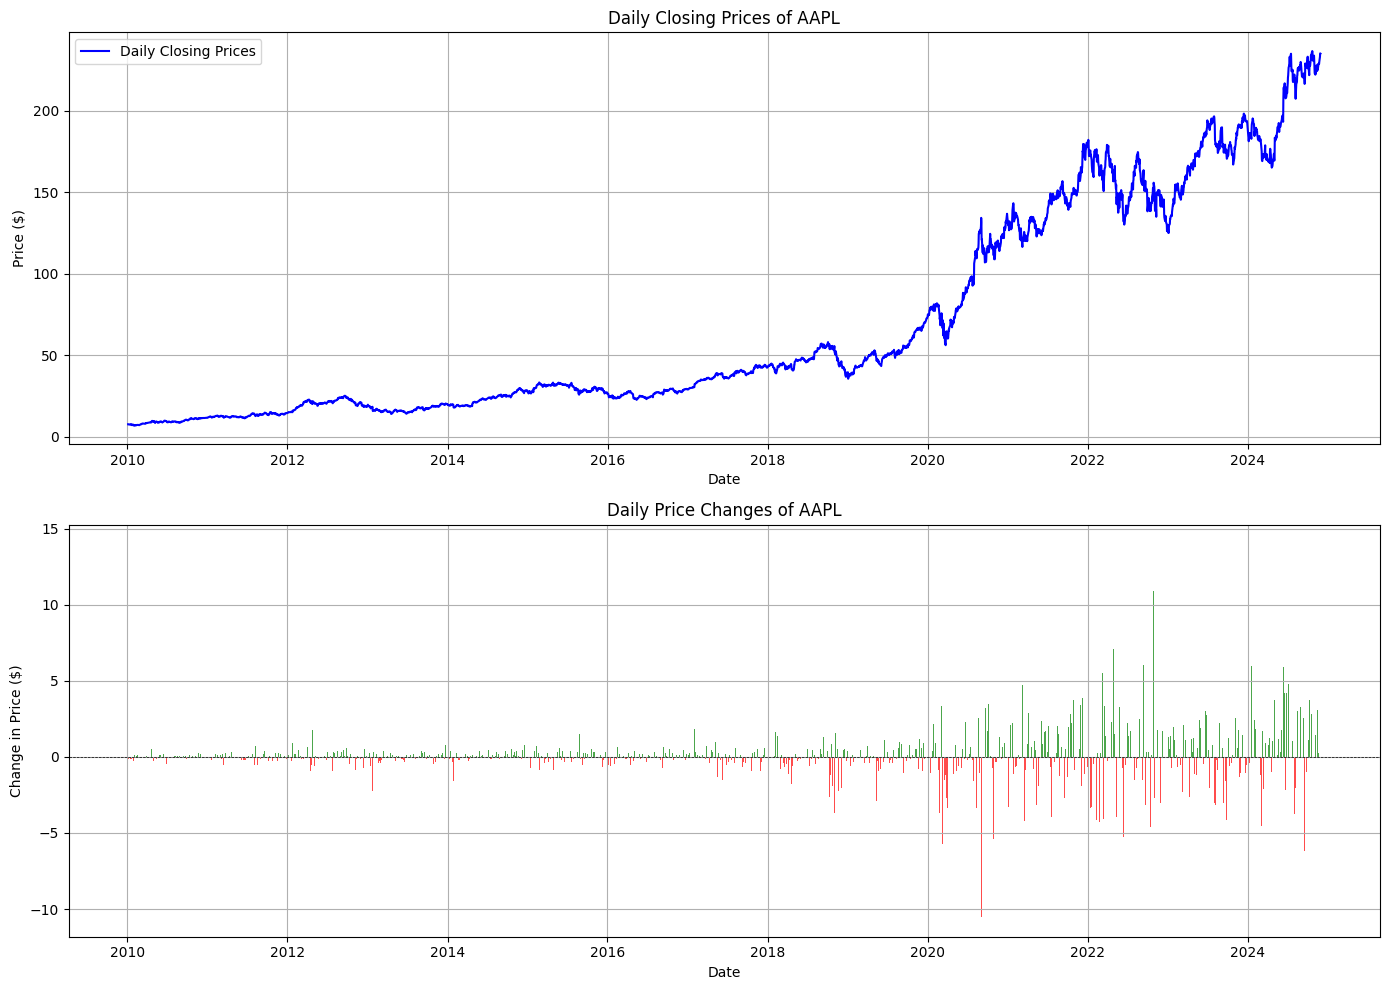

In [4]:
import matplotlib.pyplot as plt

# Load stock data
df = load_data('AAPL')  # Replace with your desired stock symbol if needed
df['Daily Change'] = df['Close'].diff()

# Plotting daily closing prices and daily price changes
plt.figure(figsize=(14, 10))

# Plotting the daily closing prices
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Daily Closing Prices', color='blue')
plt.title(f'Daily Closing Prices of {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Plotting daily price changes
plt.subplot(2, 1, 2)
colors = ['green' if change > 0 else 'red' for change in df['Daily Change'][1:]]
plt.bar(df.index[1:], df['Daily Change'][1:], color=colors, alpha=0.7)
plt.title(f'Daily Price Changes of {ticker}')
plt.xlabel('Date')
plt.ylabel('Change in Price ($)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Reference line at y=0
plt.grid()

plt.tight_layout()
plt.show()